# Single Layer Perceptron

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from itertools import product

In [2]:
drive.mount('/content/drive')

train_path = "/content/drive/MyDrive/semester_project_2.3/afdb_train_scaled.csv"
test_path  = "/content/drive/MyDrive/semester_project_2.3/afdb_test_scaled.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### If any columns are empty, we fill them with the mean and then we remove the 'label' column

In [3]:
# fill empty columns with mean
train = train.fillna(train.mean())
test  = test.fillna(test.mean())

# split features and labels
X_train = train.iloc[:, :-1].values.astype(np.float32)
y_train = train.iloc[:, -1].values.astype(int)

X_test = test.iloc[:, :-1].values.astype(np.float32)
y_test = test.iloc[:, -1].values.astype(int)

#### Prepare loaders for training

In [4]:
class SLPDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 64
train_loader = DataLoader(SLPDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(SLPDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

#### Define SLP model

In [5]:
class SLP(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super().__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SLP(input_dim=X_train.shape[1]).to(device)

class_counts = np.bincount(y_train)
class_weights = torch.tensor([class_counts[1]/class_counts[0], 1.0], dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#### Train model

In [6]:
NUM_EPOCHS = 20
best_f1 = 0
history = []

for epoch in range(NUM_EPOCHS):
    model.train()
    all_preds, all_labels = [], []
    running_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = accuracy_score(all_labels, all_preds)
    train_recall = recall_score(all_labels, all_preds)
    train_precision = precision_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds)

    if train_f1 > best_f1:
        best_f1 = train_f1
        torch.save(model.state_dict(), "best_slp.pth")

    history.append((train_loss, train_acc, train_precision, train_recall, train_f1))

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")

Epoch 1/20 - Loss: 0.4236, Acc: 0.8375, Precision: 0.7755, Recall: 0.8337, F1: 0.8035
Epoch 2/20 - Loss: 0.2095, Acc: 0.9410, Precision: 0.8818, Recall: 0.9839, F1: 0.9301
Epoch 3/20 - Loss: 0.1702, Acc: 0.9497, Precision: 0.9007, Recall: 0.9820, F1: 0.9396
Epoch 4/20 - Loss: 0.1503, Acc: 0.9539, Precision: 0.9109, Recall: 0.9802, F1: 0.9443
Epoch 5/20 - Loss: 0.1378, Acc: 0.9565, Precision: 0.9179, Recall: 0.9785, F1: 0.9472
Epoch 6/20 - Loss: 0.1290, Acc: 0.9593, Precision: 0.9244, Recall: 0.9780, F1: 0.9504
Epoch 7/20 - Loss: 0.1221, Acc: 0.9602, Precision: 0.9265, Recall: 0.9776, F1: 0.9514
Epoch 8/20 - Loss: 0.1169, Acc: 0.9631, Precision: 0.9332, Recall: 0.9773, F1: 0.9548
Epoch 9/20 - Loss: 0.1129, Acc: 0.9639, Precision: 0.9347, Recall: 0.9776, F1: 0.9557
Epoch 10/20 - Loss: 0.1095, Acc: 0.9636, Precision: 0.9345, Recall: 0.9773, F1: 0.9554
Epoch 11/20 - Loss: 0.1066, Acc: 0.9648, Precision: 0.9364, Recall: 0.9780, F1: 0.9568
Epoch 12/20 - Loss: 0.1040, Acc: 0.9649, Precision: 

#### Evaluate on test set

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.94      0.96      3497
        AFib       0.92      0.97      0.94      2500

    accuracy                           0.95      5997
   macro avg       0.95      0.95      0.95      5997
weighted avg       0.95      0.95      0.95      5997



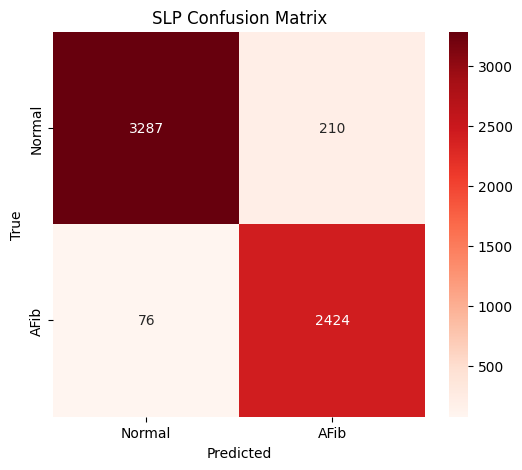

In [7]:
# load best model to evaluate on test set
model.load_state_dict(torch.load("best_slp.pth"))

# evaluate
all_preds, all_labels = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# compute metrics
acc = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

# classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Normal', 'AFib']))

# confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=['Normal','AFib'], yticklabels=['Normal','AFib'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SLP Confusion Matrix")
plt.show()